In [2]:
import pandas as pd
import numpy as np

# 1) Load
trials = pd.read_csv('Oddball_data_exported_trials_20250527.csv')   # per-trial rows
days   = pd.read_csv('Oddball_data_exported_20250527.csv')          # per-day rows

print(days.columns)

print(trials.columns)

import pandas as pd
import numpy as np

days = days.loc[days['genotype'] == 'WT']
days = days.loc[days['rat_name'] == 'RP4']
days = days.loc[days['position'] == 4]
days = days[['date', 'file_name', 'task', 'UUID']]

trials = trials.loc[trials['rat_ID'] == 140]


trials = trials[['Stim_ID', 'Trial_type', 'UUID', 'Trial_number', 'Response', 'Reaction_(s)']]

days_trials = trials.merge(days, on='UUID', how='inner')

days_trials = days_trials[['date', 'Trial_number', 'task', 'Trial_type', 'file_name', 'Stim_ID', 'Reaction_(s)', 'Response']]

days_trials.columns = ['Date', 'Trial_number', 'Global', 'Trial_logic', 'Frequency', 'Position', 'Decision', 'Response']

days_trials['Trial_logic'] = days_trials['Trial_logic'].replace({5: 'HM', 0: 'FC'})
days_trials['Trial_logic'] = pd.Categorical(days_trials['Trial_logic'], categories=['HM','FC'])

days_trials['Frequency'] = (
    days_trials['Frequency']
    .astype(str)
    .str.extract(r'(?i)(\d+)\s*kHz', expand=False)  # case-insensitive 'kHz'
    .astype(int)
)

days_trials = days_trials.loc[days_trials['Global'].isin(['Base case', 'Probe trials', 'Catch trials'])]

# Masks
m_HM   = days_trials['Trial_logic'].eq('HM')
m_FC   = days_trials['Trial_logic'].eq('FC')
m_Hit  = days_trials['Response'].eq('Hit')
m_FA   = days_trials['Response'].eq('FA')
m_Miss = days_trials['Response'].eq('Miss')
m_CR   = days_trials['Response'].eq('CR')

# Helper: numeric versions
pos_num = pd.to_numeric(
    days_trials['Position'].astype(str).str.extract(r'(\d+)', expand=False),
    errors='coerce'
)
dec_num = pd.to_numeric(days_trials['Decision'], errors='coerce')

# Floor-division by 0.750 then +1 (use floor to match // semantics with floats)
fa_calc = (np.floor(dec_num / 0.750) + 1).astype('Int64')

# 1) HM & Hit  -> Decision = Position
days_trials.loc[m_HM & m_Hit, 'Decision'] = pos_num[m_HM & m_Hit]

# 2) HM & FA   -> Decision = (Decision // 0.750) + 1
days_trials.loc[m_HM & m_FA, 'Decision'] = fa_calc[m_HM & m_FA]

# 3) HM & Miss -> Decision = -1
days_trials.loc[m_HM & m_Miss, 'Decision'] = -1

# 4) FC & CR   -> Decision = 7
days_trials.loc[m_FC & m_CR, 'Decision'] = 7

# 5) FC & FA   -> Decision = (Decision // 0.750) + 1
days_trials.loc[m_FC & m_FA, 'Decision'] = fa_calc[m_FC & m_FA]

# print(trials)

days_trials = days_trials[['Date', 'Global', 'Trial_number', 'Frequency', 'Position', 'Decision']]

days_trials['Decision'] = days_trials['Decision'] - 1
days_trials['Position'] = days_trials['Position'] - 1

print(days_trials)

Index(['date', 'rat_name', 'rat_ID', 'DOB', 'Sex', 'Genotype', 'HL_date',
       'file_name', 'experiment', 'phase', 'task', 'detail', 'stim_type',
       'analysis_type', 'complete_block_count', 'trial_count', 'hit_percent',
       'FA_percent', 'UUID', 'position', 'FA', 'trials', 'FA_percent_detailed',
       'Dur (ms)', 'Freq (kHz)', 'Rxn', 'line', 'genotype'],
      dtype='object')
Index(['Time_since_file_start_(s)', 'Stim_ID', 'Trial_type',
       'Attempts_to_complete', 'Response', 'Reaction_(s)', 'Type',
       'Stim Source', 'Freq (kHz)', 'Inten (dB)', 'Dur (ms)',
       'Nose Out TL (s)', 'Time Out (s)', 'Train Setting',
       'Extra Check Point (s)', 'Delay (s)', 'Trial_number', 'Block_number',
       'complete_block_number', 'UUID', 'rat_ID', 'rat_name', 'DOB', 'Sex',
       'Genotype', 'HL_date'],
      dtype='object')
           Date     Global  Trial_number  Frequency  Position  Decision
6125   20230502  Base case             1          4         5       2.0
6126   20230

In [3]:
# already sorted & reindexed:
days_trials = days_trials.sort_values(['Date','Trial_number']).reset_index(drop=True)

def find_intervals_by_index(df, label_value, label_col='Global'):
    # True where we're in the target phase
    mask = df[label_col].astype(str).str.strip().str.casefold().eq(label_value.casefold())
    # New run whenever mask flips (contiguous by row index)
    run_id = mask.ne(mask.shift()).cumsum()

    out = (df.loc[mask]
             .assign(row=lambda d: d.index)                # capture row index
             .groupby(run_id[mask], as_index=False)
             .agg(start_row=('row','min'),
                  end_row=('row','max'),
                  n_rows=('row','size'),
                  start_trial=('Trial_number','first'),
                  end_trial=('Trial_number','last'))
          )
    out.insert(0, 'label', label_value)
    return out

probe_intervals = find_intervals_by_index(days_trials, 'Probe trials')
catch_intervals = find_intervals_by_index(days_trials, 'Catch trials')

print("Probe intervals:\n", probe_intervals.to_string(index=False))
print("\nCatch intervals:\n", catch_intervals.to_string(index=False))


Probe intervals:
        label  start_row  end_row  n_rows  start_trial  end_trial
Probe trials       5410     5786     377            1        377
Probe trials       6506     6871     366            1        366
Probe trials       7900     8280     381            1        381
Probe trials       9022     9389     368            1        368
Probe trials      10138    10513     376            1        376
Probe trials      11244    11609     366            1        366
Probe trials      12307    12684     378            1        378
Probe trials      13391    13724     334            1        334
Probe trials      17545    17751     207            1        207
Probe trials      18479    18818     340            1        340
Probe trials      19092    19490     399            1        399
Probe trials      19854    20239     386            1        386
Probe trials      20436    20815     380            1        380
Probe trials      21214    21567     354            1        354
Probe t

C:\Users\Fatbu\AppData\Local\Temp\ipykernel_4792\3510368493.py:13: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  .agg(start_row=('row','min'),
C:\Users\Fatbu\AppData\Local\Temp\ipykernel_4792\3510368493.py:13: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  .agg(start_row=('row','min'),


### Perceptual Decision Making

In [4]:
import numpy as np

#noise = P(O_t+1 | true k_t, freq_t)
#prior = P(O_t+1 | O_1:t)
#P(O_t+1 | O_1:t, true k_t, freq_t)
def decision_prior(lamdha, misses, deviant_position):
    #lamdha will have to be small enough where it still decays 
    #but is able to maintain a steady percentage (approx 1% for each pos)
    pos = np.zeros(7, dtype = float)
    pos[deviant_position] = 1.0
    percentages = np.zeros(7, dtype = float)
    
    if (deviant_position < 6 and deviant_position > 2):
        output = (1.0 - lamdha)*pos + lamdha * np.array([1/3, 1/3, 1/3, 0.0, 0.0, 0.0, 0.0])
        percentages = (1.0 - misses)*output + misses * np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
    elif (deviant_position == 6):
        percentages = (1.0 - lamdha)*pos + lamdha * np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6, 0.0])
    
    pos = np.array([0, 1, 2, 3, 4, 5, 6])
    decision = np.random.choice(pos, p=percentages)

    return decision

### Modeling

In [5]:
import numpy as np
import matplotlib.pyplot as plt

observations = ['Dev at 1', 'Dev at 2','Dev at 3','Dev at 4','Dev at 5','Dev at 6', 'No deviant']
frequencies = [4, 8, 16, 32]

def exponential_model(alpha_param, lamdha_param, misses_param):

    ### Initialize Global Variables

    def initialize_likelihoods(alpha_, lamdha_, misses_):
        lamdha = lamdha_

        alpha = alpha_

        misses = misses_

        return alpha, lamdha, misses

    alpha, lamdha, misses  = initialize_likelihoods(alpha_param, lamdha_param, misses_param)



    ### Helper Functions ... Could use prior as a free variable

    def initialize_priors(belief_over_time_, decision_over_time_, decision_history_):

        if (belief_over_time_ is None or decision_history_ is None):
            belief_over_time = []  
            decision_over_time = []
            decision_history = []         
        else:
            belief_over_time = belief_over_time_  
            decision_over_time = decision_over_time_
            decision_history = decision_history_

        deviant_given_sequence = np.array([1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])      


        return deviant_given_sequence, belief_over_time, decision_over_time, decision_history


    def update_priors_simplified(prior_belief, decision_history):    
        
    # Initialize the updated prior as a copy of the original prior
        updated_prior = prior_belief.copy()

        if(decision_history == []):
            return prior_belief

        for pos in range(len(prior_belief)):
            Ct = 0
            if (decision_history[len(decision_history) - 1] == pos):
                Ct = 1

            updated_prior[pos] = alpha * Ct + (1 - alpha) * updated_prior[pos]

        return updated_prior




    ######## FUNCTION FOR RUNNING TRIALS ########




    def run_trials(dirichlet_prior_belief_ = None, belief_over_time_ = None, decision_over_time_ = None, decision_history = None):
        
        deviant_given_sequence, belief_over_time, decision_over_time, decision_history = initialize_priors(
            belief_over_time_, decision_over_time_, decision_history)

        dates = days_trials['Date'].unique() #in ascending order

        for date in dates:
            df_copy = days_trials.copy()
            df_copy = df_copy.loc[df_copy['Date'] == date]  

            for trial in range(len(df_copy['Trial_number'])):
                deviant_position = int(df_copy.iloc[trial]['Position'])
                f_val = int(df_copy.iloc[trial]['Frequency'])   # get the value at this trial
                f_index = frequencies.index(f_val)

                decision = decision_prior(lamdha, misses, deviant_position)
                
                decision_history.append(decision)

                # After each trial, update the predicted observation based on the new decision sequence
                deviant_given_sequence = update_priors_simplified(deviant_given_sequence, decision_history)
                belief_over_time.append(deviant_given_sequence.copy())

        
        return belief_over_time, decision_over_time, decision_history

    # Step 4: Plot the belief evolution over time
    def plot_belief_evolution(belief_over_time,
                          probe_intervals=None,
                          catch_intervals=None,
                          figsize=(10, 6),
                          savepath="exponential_bias.svg"):

        B = np.asarray(belief_over_time)
        T = B.shape[0]

        fig, ax = plt.subplots(figsize=figsize)

        # Positions 1..6
        for i in range(6):
            ax.plot(B[:, i], label=f"Position {i+1}", linewidth=1.5)

        # Position 7 as "No deviant"
        ax.plot(B[:, 6], label="No deviant", linestyle='--', color='black', linewidth=1.5)

        # ---- Mark Probe blocks: single vertical line at block start ----
        if probe_intervals is not None and len(probe_intervals) > 0:
            added_probe_label = False
            for _, r in probe_intervals.iterrows():
                x = int(r['start_row'])
                ax.axvline(x=x, color='tab:red', linestyle='--', linewidth=1.2, alpha=0.9,
                        label=None if added_probe_label else "Probe start")
                added_probe_label = True

        # ---- Mark Catch blocks: shaded span + thin boundary lines ----
        if catch_intervals is not None and len(catch_intervals) > 0:
            added_catch_span_label = False
            added_catch_edge_label = False
            for _, r in catch_intervals.iterrows():
                xs, xe = int(r['start_row']), int(r['end_row'])
                ax.axvspan(xs, xe, color='tab:blue', alpha=0.08,
                        label=None if added_catch_span_label else "Catch interval")
                added_catch_span_label = True
                # optional boundary lines for extra clarity
                ax.axvline(x=xs, color='tab:blue', linestyle='-', linewidth=0.8, alpha=0.6,
                        label=None if added_catch_edge_label else "Catch boundary")
                ax.axvline(x=xe, color='tab:blue', linestyle='-', linewidth=0.8, alpha=0.6,
                        label=None)
                added_catch_edge_label = True

        ax.set_xlim(0, T-1)
        ax.set_xlabel("Trial")
        ax.set_ylabel("Belief")
        ax.set_title("Evolution of Belief Over Time")

        # legend outside on the right
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        leg = ax.legend(
            by_label.values(), by_label.keys(),
            loc='center left', bbox_to_anchor=(1.02, 0.5),
            title='Legend',                  # ← title text
            frameon=True, fancybox=True,     # ← show box
            framealpha=1.0,                  # opaque box
            edgecolor='0.3',                 # box outline color
            ncol=1, fontsize=9, title_fontsize=10,
            borderpad=0.3, labelspacing=0.3, handlelength=1.2, handletextpad=0.5
        )
        leg.get_frame().set_linewidth(1.0)   # optional: thicker border


        plt.tight_layout()
        plt.savefig("unbias exponential.svg", format="svg", bbox_inches="tight")
        plt.show()

    belief_over_time, decision_over_time, decision_history = run_trials()
    
    plot_belief_evolution(np.asarray(belief_over_time),
                      probe_intervals=probe_intervals,
                      catch_intervals=catch_intervals)

    return belief_over_time

### Model Fitting

[2. 3. 3. ... 3. 5. 4.]
|   iter    |  target   | alpha_... |
-------------------------------------


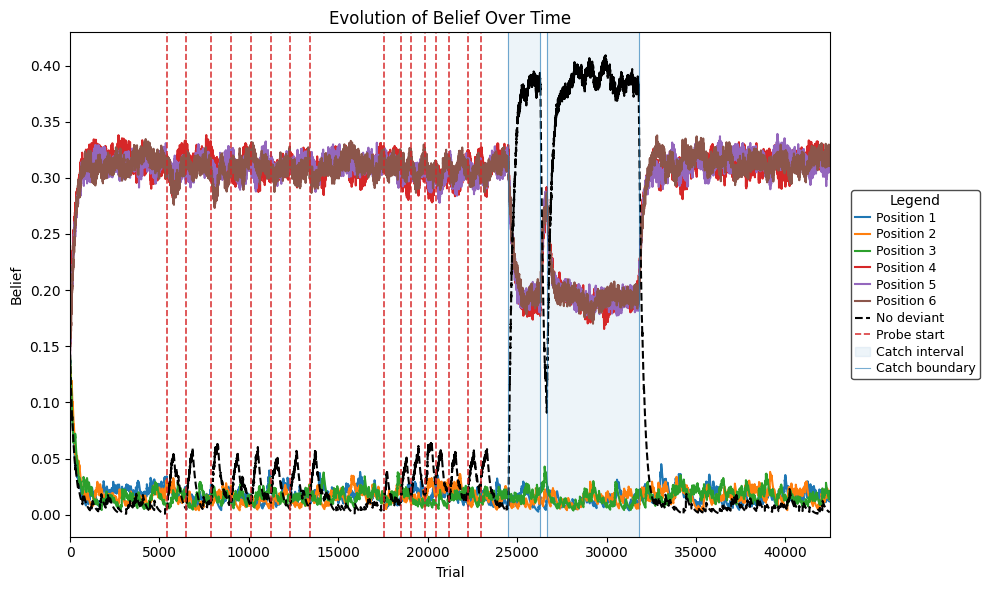

| 1         | -56424.75 | 0.0043708 |


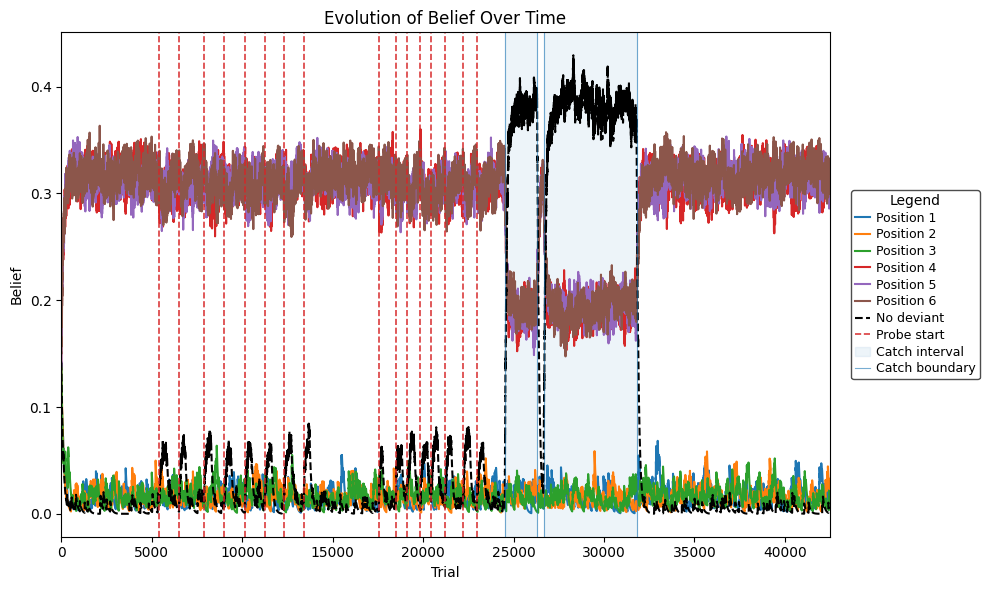

| 2         | -56060.04 | 0.0095564 |


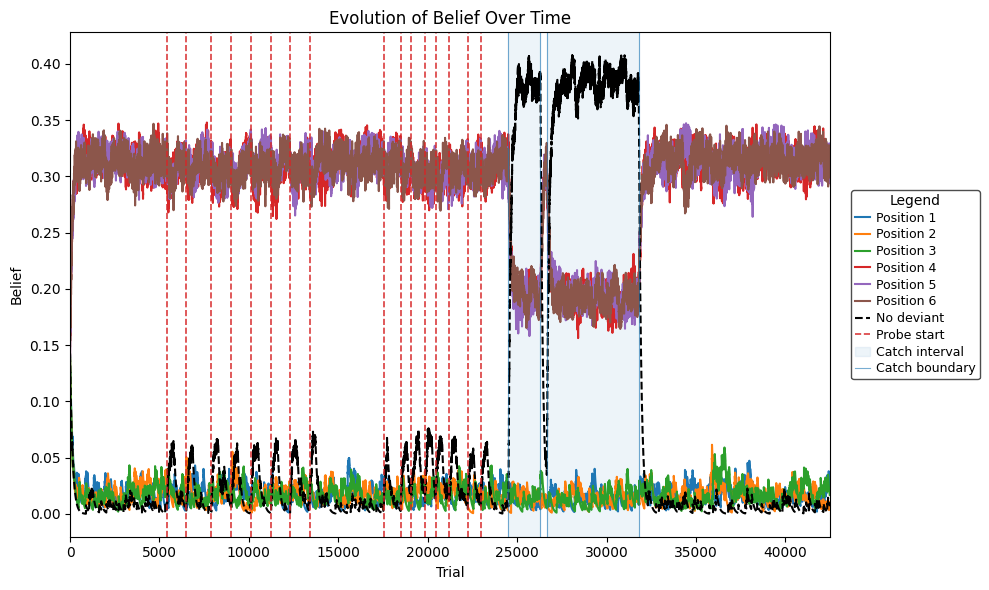

| 3         | -56189.20 | 0.0075879 |


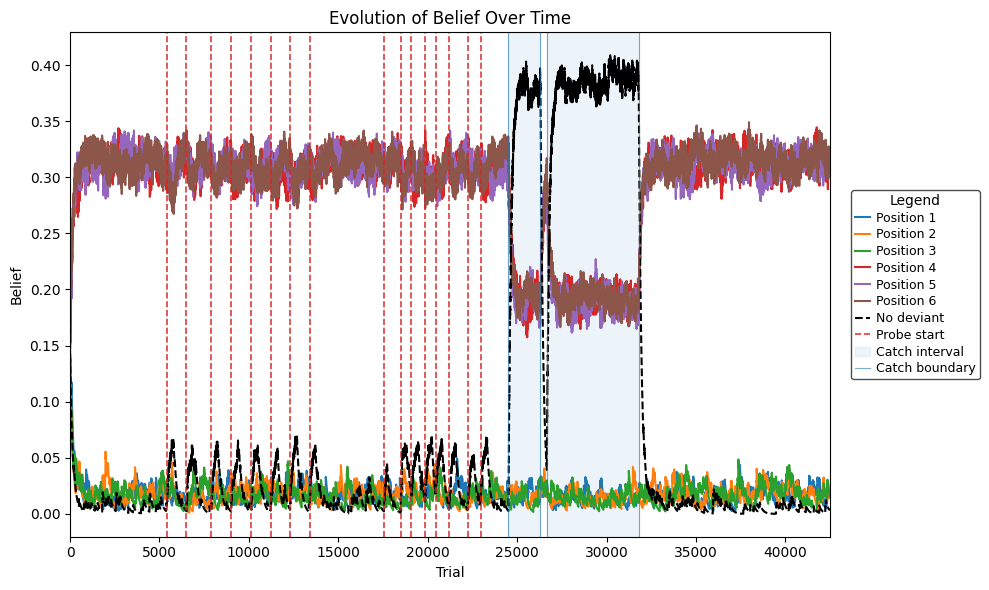

| 4         | -56234.90 | 0.0063879 |


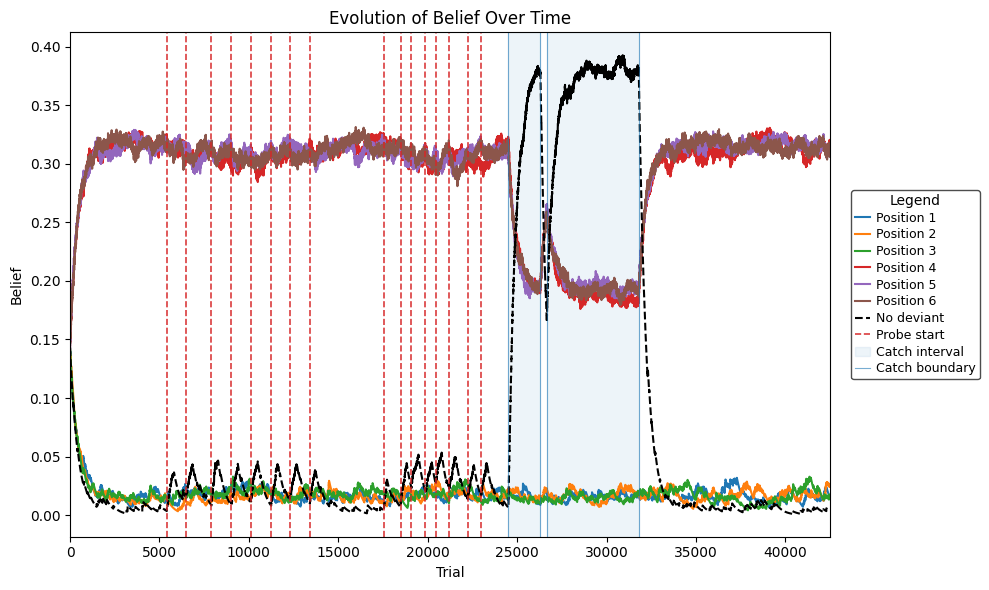

| 5         | -56683.90 | 0.0024041 |


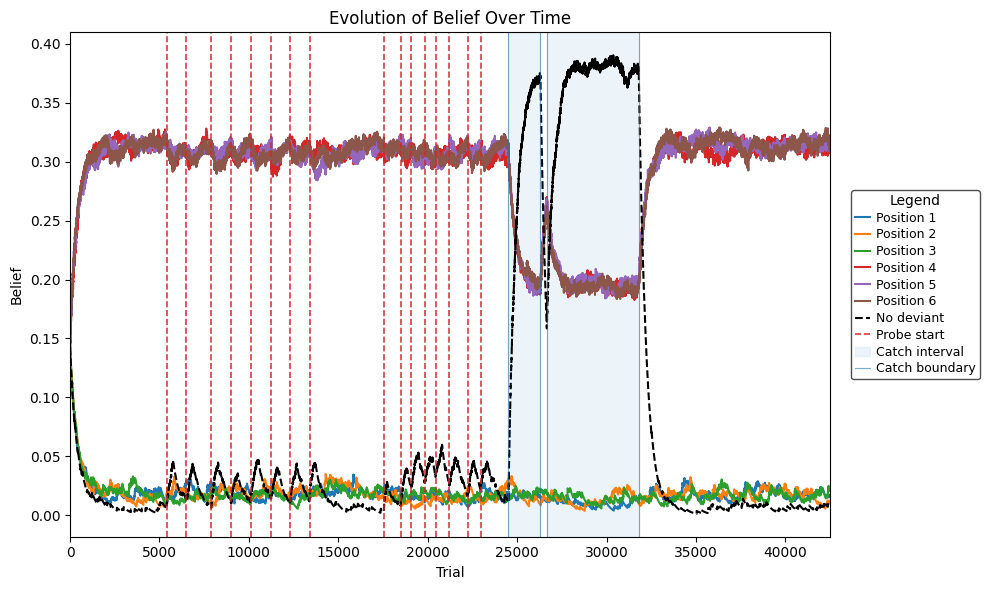

| 6         | -56684.65 | 0.0024039 |


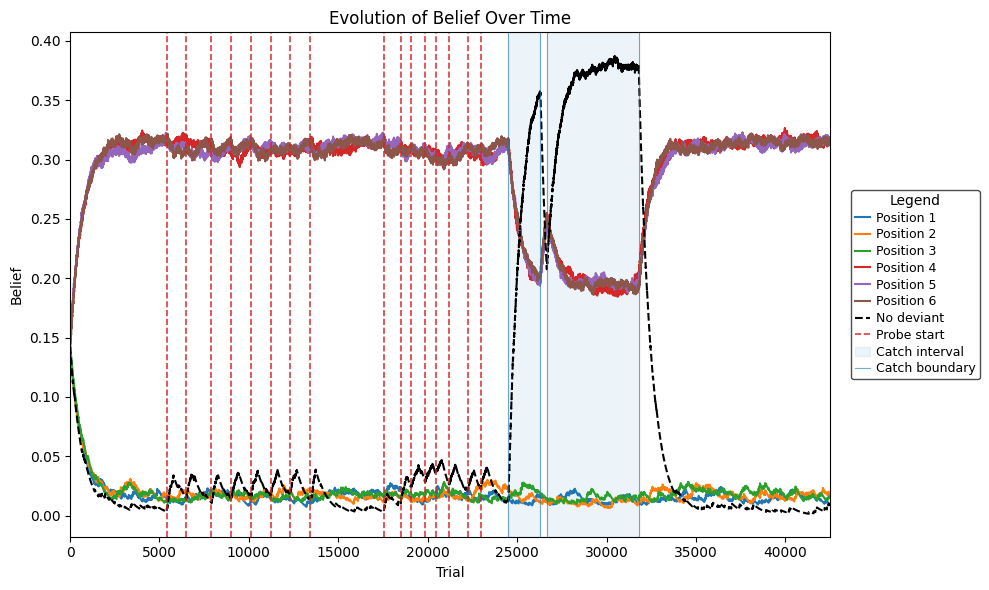

| 7         | -56957.81 | 0.0015227 |


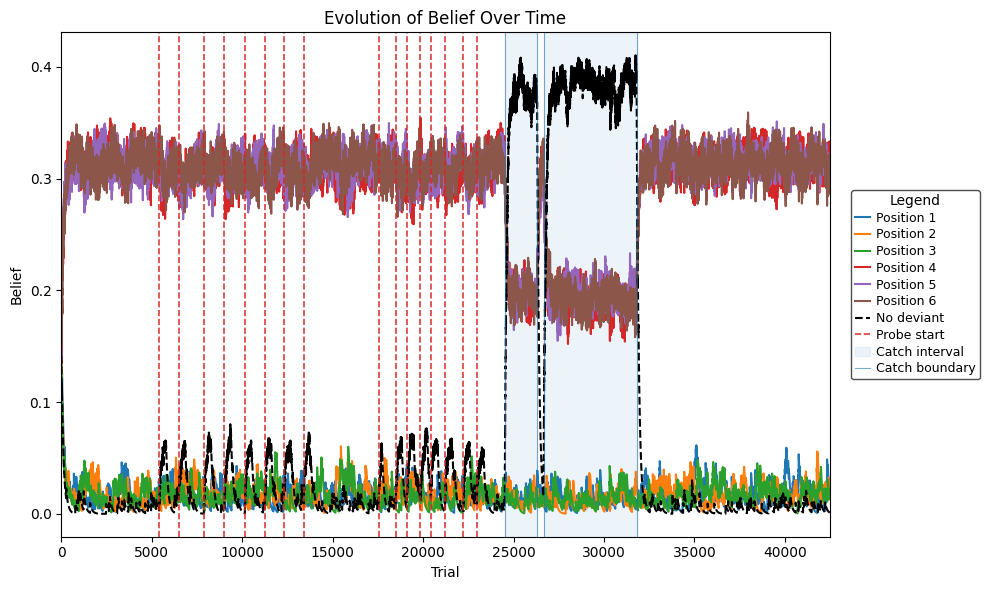

| 8         | -56122.97 | 0.0087955 |


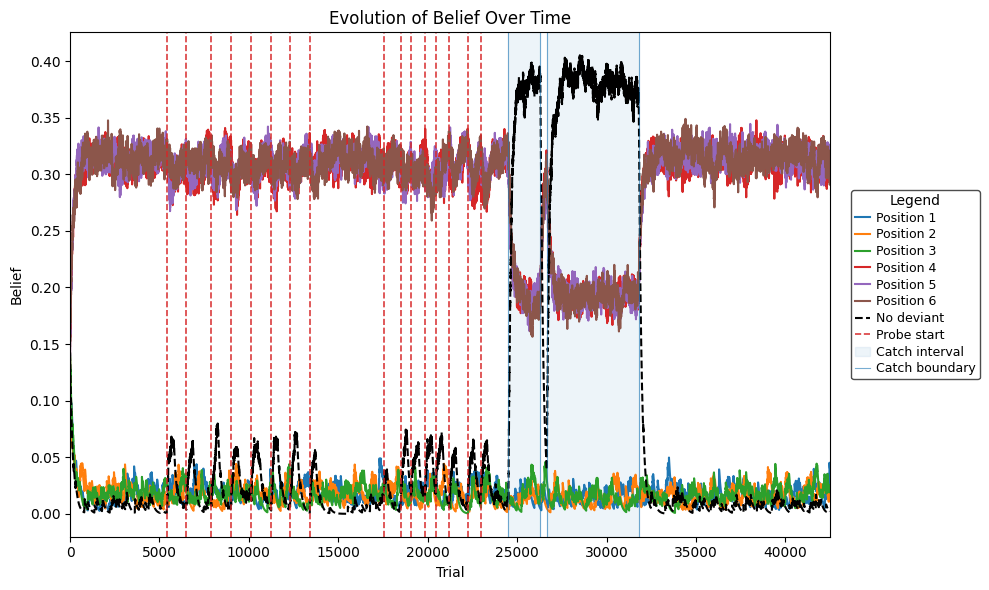

| 9         | -56268.78 | 0.0064100 |


KeyboardInterrupt: 

In [6]:
from bayes_opt import BayesianOptimization
import math

data = days_trials['Decision'].to_numpy()
deviant_data = days_trials['Position'].to_numpy()

print(data)

#f1 set to zero as reference variance
def neg_log_likelihood(alpha_param):
    priors = exponential_model(alpha_param, 0.0521086, 0.0062037)
    priors = np.asarray(priors, dtype=float)

    if len(priors) != len(data):
        raise ValueError(f"Length mismatch: priors={len(priors)} vs data={len(data)}")

    nll = 0.0
    for i in range(len(priors)):
        k = int(data[i])           # your Decision column (already minus 1)
        if k == -2:
            t = int(deviant_data[i])   # 0-based true dev position; -1 if unknown
            p = priors[i, 0:t].sum()   # probability of choosing any bin AFTER true dev
        elif (k == 7):
            continue
        else:
            # normal case: probability of the chosen bin
            p = priors[i, k]     
            if (p <= 0):
                print(priors[i, :])             # belief mass at that class
        nll -= math.log(p)                # accumulate negative log-likelihood
    return -nll


pbounds = {
    'alpha_param': (0.001, 0.01),
    # 'lamdha_param': (0.00001, 0.1),
    # 'misses_param': (0.00001, 0.1)
}

# Initialize the optimizer
optimizer = BayesianOptimization(
    f=neg_log_likelihood,
    pbounds=pbounds,
    random_state=42,
    verbose=2
)

# Run optimization
optimizer.maximize(
    init_points=10,  # random samples before GP fitting
    n_iter=20        # number of iterations of Bayesian optimization
)    

In [ ]:
-46235.43 | alpha 0.0018476 | lamdha 0.0006260 | 0.4855639 | 0.3233900 | 0.4310112 | -0.530650 | -0.484837 | -0.569888 | 0.2630443 | 0.6174512 | 0.7843596 | -0.664079 | -0.418226 

SyntaxError: invalid syntax (1946397666.py, line 1)

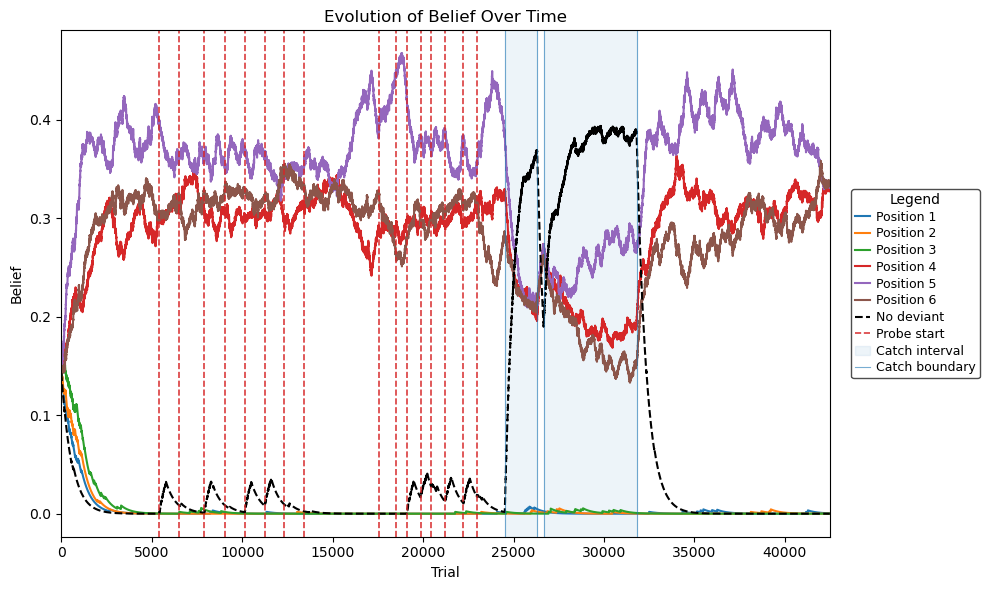

[array([0.04277946, 0.06079775, 0.10465509, 0.13473328, 0.28193308,
        0.37404922, 0.00105212]),
 array([0.08659713, 0.12243824, 0.14103399, 0.29654713, 0.23318857,
        0.11109147, 0.00910347]),
 array([0.04255058, 0.060472  , 0.10409354, 0.13574849, 0.28405071,
        0.3720382 , 0.00104647]),
 array([0.04234658, 0.06018165, 0.10359301, 0.13509444, 0.28268212,
        0.37506078, 0.00104143]),
 array([0.05848722, 0.08317991, 0.1146315 , 0.22851066, 0.28117544,
        0.23075569, 0.00325959]),
 array([0.08700548, 0.1214365 , 0.14170303, 0.29793473, 0.23127746,
        0.11161393, 0.00902886]),
 array([0.05818996, 0.0827567 , 0.11553384, 0.22734509, 0.28335277,
        0.22957867, 0.00324296]),
 array([0.08648943, 0.12071575, 0.14086179, 0.29616339, 0.23584411,
        0.11095035, 0.00897518]),
 array([0.08633238, 0.1204964 , 0.14242487, 0.2956243 , 0.23541481,
        0.11074839, 0.00895885]),
 array([0.05768705, 0.08204071, 0.11601484, 0.22537318, 0.288082  ,
        0.2275

In [ ]:
pos_sigma_ = np.array([ 0.4855639, 0.3233900 , 0.4310112 , -0.530650 , -0.484837 , -0.569888 , 0.2630443])
freq_sigma_ = np.array([ 0.6174512 , 0.7843596 , -0.664079 , -0.418226 ])

pos_sigma_ -= pos_sigma_.mean()
freq_sigma_ -= freq_sigma_.mean()

exponential_model(0.0018476, 0.0006260, pos_sigma_, freq_sigma_)